In [2]:
%pip install mne
%pip install hurst
%pip install keras-tcn
%pip install git+https://github.com/forrestbao/pyeeg.git
%pip install git+https://www.github.com/keras-team/keras-contrib.git

Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable

[notice] A new release of pip is available: 23.3 -> 23.3.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
  Cloning https://github.com/forrestbao/pyeeg.git to /tmp/pip-req-build-9eehlpbl
  Running command git clone --filter=blob:none --quiet https://github.com/fo

In [3]:
%matplotlib inline

import glob
import math
import ntpath
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import edfreader
import models
import joblib
import mne
import pyeeg
import pickle
import warnings
warnings.filterwarnings('ignore')
from hurst import compute_Hc
from scipy.signal import butter, lfilter
from matplotlib.backends.backend_pdf import PdfPages
from mne.datasets.sleep_physionet._utils import _fetch_one, _data_path, AGE_SLEEP_RECORDS
from datetime import datetime
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, CSVLogger
from sklearn.metrics import f1_score, accuracy_score, classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from xgboost import XGBClassifier

VBS = True  # constant boolean to enable/disbale verbose
EPOCH_SEC_SIZE = 30  # Epoch duration selection
seed = 42  # seed value for the random seeds
batch_size = 64
number_of_subj = 50

# values to label the stages
UNKNOWN = -1
W = 0
N1 = 1
N2 = 2
N3 = 3
REM = 4

# making string dictionary for the label values
label_dict = {
    "UNKNOWN"  : UNKNOWN,
    "W"        : W,
    "N1"       : N1,
    "N2"       : N2,
    "N3"       : N3,
    "REM"      : REM
}

# converting from label values to strings
class_dict = {
    -1: "UNKNOWN",
    0 : "W",
    1 : "N1",
    2 : "N2",
    3 : "N3",
    4 : "REM"
}

# annotation dictionary to convert from string to label values
annot2label = {
    "Sleep stage ?": -1,
    "Movement time": -1,
    "Sleep stage W": 0,
    "Sleep stage 1": 1,
    "Sleep stage 2": 2,
    "Sleep stage 3": 3,
    "Sleep stage 4": 3,
    "Sleep stage R": 4
}
project_path = os.path.abspath(os.getcwd())  # finding the current project path in windows

2023-10-28 17:39:12.161521: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 17:39:12.212457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-28 17:39:12.212519: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-28 17:39:12.212569: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-28 17:39:12.223894: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-28 17:39:12.224860: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

<h3> Localizing fetch_data function to import all subjects </h3>


In [4]:
data_path = _data_path
BASE_URL = 'https://physionet.org/physiobank/database/sleep-edfx/sleep-cassette/'
def fetch_data(subjects, recording=[1, 2], path=None, force_update=False,
                base_url=BASE_URL,
               verbose=None): 
    records = np.loadtxt(AGE_SLEEP_RECORDS,
                         skiprows=1,
                         delimiter=',',
                         usecols=(0, 1, 2, 6, 7),
                         dtype={'names': ('subject', 'record', 'type', 'sha',
                                          'fname'),
                                'formats': ('<i2', 'i1', '<S9', 'S40', '<S22')}
                         )
    psg_records = records[np.where(records['type'] == b'PSG')]
    hyp_records = records[np.where(records['type'] == b'Hypnogram')]

    path = data_path(path=path)
    params = [path, force_update, base_url]
    fnames = []
    for subject in subjects:
        for idx in np.where(psg_records['subject'] == subject)[0]:
            if psg_records['record'][idx] in recording:
                psg_fname = _fetch_one(psg_records['fname'][idx].decode(),
                                       psg_records['sha'][idx].decode(),
                                       *params)
                hyp_fname = _fetch_one(hyp_records['fname'][idx].decode(),
                                       hyp_records['sha'][idx].decode(),
                                       *params)
                fnames.append([psg_fname, hyp_fname])

    return fnames

<h3> Reading input data </h3>


In [5]:
subjects_list = []  # list to keep the address of the subject data
except_sub = [13, 36, 52]  # omitting the subjects with incomplete data
for i in range(83):
    if i in except_sub:
        continue
    subjects_list.append(i)
# fetching data of each subject and
subject_files = fetch_data(subjects=subjects_list, recording=[1, 2], path= project_path)
mapping = {'EOG horizontal': 'eog',
           'Resp oro-nasal': 'misc',
           'EMG submental': 'misc',
           'Temp rectal': 'misc',
           'Event marker': 'misc'}

<h3> Sampling data and saving the results in NPZ format </h3>


In [6]:
ch_labels = 'EEG Fpz-Cz'  # channels to be selected
data_frames = []
if VBS:
    print("Importing data into dataframes:")
output_path = os.path.join(project_path, "NPZ_files")  # path to save the npz files
# loop to preprocess input data and save the results in npz files to be used in our models later
for item in tqdm(subject_files):
    filename = ntpath.basename(item[0][0]).replace("-PSG.edf", ".npz")  # reading the PSG files
    if not os.path.exists(os.path.join(output_path, filename)):
        raw_train = mne.io.read_raw_edf(item[0][0], verbose=False)
        sampling_rate = raw_train.info['sfreq']
        raw_ch_df = raw_train.to_data_frame()[ch_labels]
        raw_ch_df = raw_ch_df.to_frame()
        raw_ch_df.set_index(np.arange(len(raw_ch_df)))

        # reading the raw headers using the EDFReader function from edfreader
        f = open(item[0][0], 'r', errors='ignore', encoding='utf-8')
        head_raw_read = edfreader.BaseEDFReader(f)
        head_raw_read.read_header()
        head_raw = head_raw_read.header
        f.close()
        raw_start_time = datetime.strptime(head_raw['date_time'], "%Y-%m-%d %H:%M:%S")

        # read annotations from hypnogram file

        f = open(item[1][0], 'r')
        annot_raw_read = edfreader.BaseEDFReader(f)
        annot_raw_read.read_header()
        annot_raw = annot_raw_read.header
        temp, temp, total_annot = zip(*annot_raw_read.records())
        f.close()
        annot_start_time = datetime.strptime(annot_raw['date_time'], "%Y-%m-%d %H:%M:%S")
        assert raw_start_time == annot_start_time  # making sure that the PSG files and hypnogram files are in sync
        remove_idx = []    # list to keep the indicies of data that will be removed
        labels = []        # list to keep the indicies of data that have labels
        label_idx = []

        # selecting the indicies of known labels and adding the rest to remove_idx list
        for annot in total_annot[0]:
            onset_sec, duration_sec, annot_char = annot
            annot_str = "".join(annot_char)
            label = annot2label[annot_str]
            if label != UNKNOWN:
                if duration_sec % EPOCH_SEC_SIZE != 0:
                    raise Exception("Please choose another epoch duration!")
                duration_epoch = int(duration_sec / EPOCH_SEC_SIZE)
                label_epoch = np.ones(duration_epoch, dtype=int) * label
                labels.append(label_epoch)
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                label_idx.append(idx)
            else:
                idx = int(onset_sec * sampling_rate) + np.arange(duration_sec * sampling_rate, dtype=int)
                remove_idx.append(idx)
        labels = np.hstack(labels)
        if len(remove_idx) > 0:
            remove_idx = np.hstack(remove_idx)
            select_idx = np.setdiff1d(np.arange(len(raw_ch_df)), remove_idx)
        else:
            select_idx = np.arange(len(raw_ch_df))

        # filtering data with labels only
        label_idx = np.hstack(label_idx)
        select_idx = np.intersect1d(select_idx, label_idx)

        # removing extra indicies
        if len(label_idx) > len(select_idx):
            extra_idx = np.setdiff1d(label_idx, select_idx)
            # trimming the tail
            if np.all(extra_idx > select_idx[-1]):
                n_trims = len(select_idx) % int(EPOCH_SEC_SIZE * sampling_rate)
                n_label_trims = int(math.ceil(n_trims / (EPOCH_SEC_SIZE * sampling_rate)))
                select_idx = select_idx[:-n_trims]
                labels = labels[:-n_label_trims]

        # removing all unknown and movement labels
        raw_ch = raw_ch_df.values[select_idx]

        # check if we can split into epochs' size
        if len(raw_ch) % (EPOCH_SEC_SIZE * sampling_rate) != 0:
            raise Exception("Please choose anothe epoch duration!")
        n_epochs = len(raw_ch) / (EPOCH_SEC_SIZE * sampling_rate)

        # get epochs and their corresponding labels
        x = np.asarray(np.split(raw_ch, n_epochs)).astype(np.float32)
        y = labels.astype(np.int32)

        assert len(x) == len(y)

        # select on sleep periods
        w_edge_mins = 30
        nw_idx = np.where(y != label_dict["W"])[0]
        start_idx = nw_idx[0] - (w_edge_mins * 2)
        end_idx = nw_idx[-1] + (w_edge_mins * 2)
        if start_idx < 0: start_idx = 0
        if end_idx >= len(y): end_idx = len(y) - 1
        select_idx = np.arange(start_idx, end_idx+1)
        x = x[select_idx]
        y = y[select_idx]

        # file structure for saving
        save_dict = {
            "x": x,
            "y": y,
            "fs": sampling_rate,
            "ch_label": ch_labels,
            "header_raw": head_raw,
            "header_annotation": annot_raw,
        }
        if not os.path.exists(output_path):
            os.makedirs(output_path)
        np.savez(os.path.join(output_path, filename), **save_dict)

Importing data into dataframes:


100%|██████████| 150/150 [00:00<00:00, 72683.18it/s]


<h3> Plotting the first 2 subjects and saving the results in a PDF file </h3>


  0%|          | 0/2 [00:00<?, ?it/s]

Using matplotlib as 2D backend.


<Figure size 640x480 with 0 Axes>

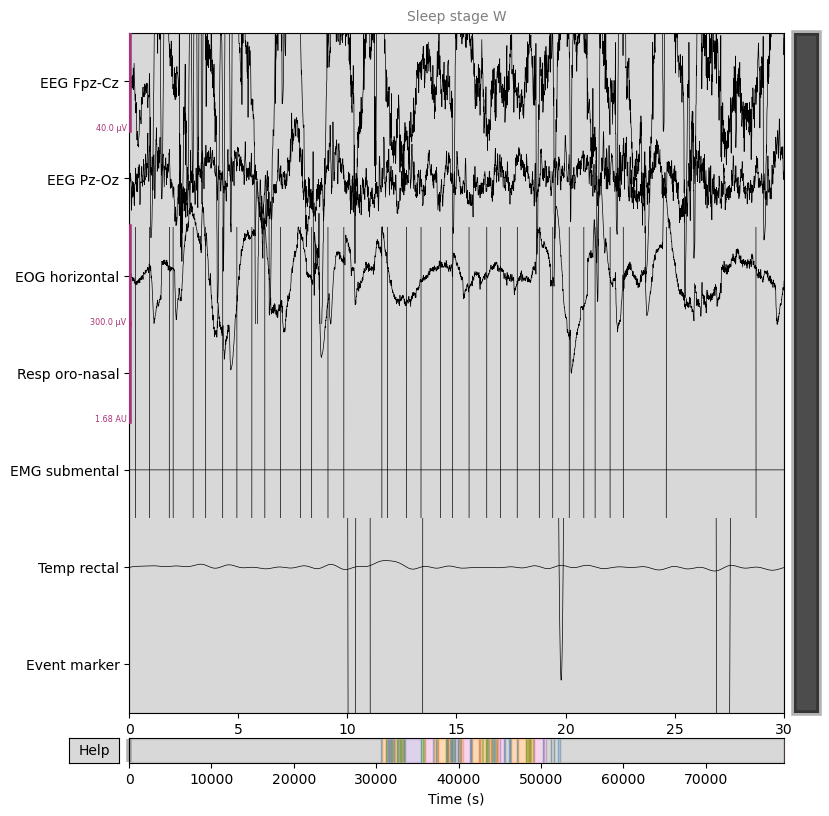

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


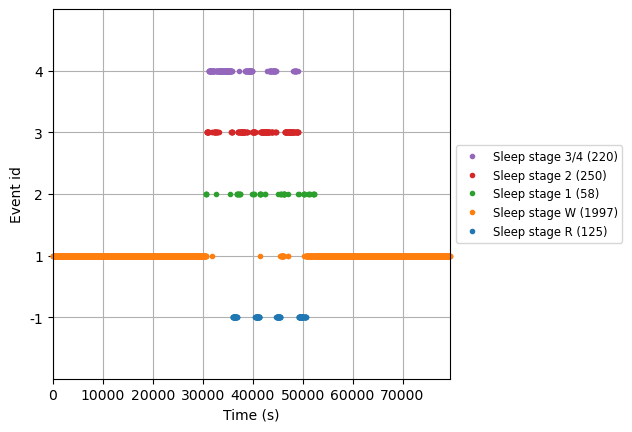

 50%|█████     | 1/2 [00:04<00:04,  4.84s/it]

<Figure size 640x480 with 0 Axes>

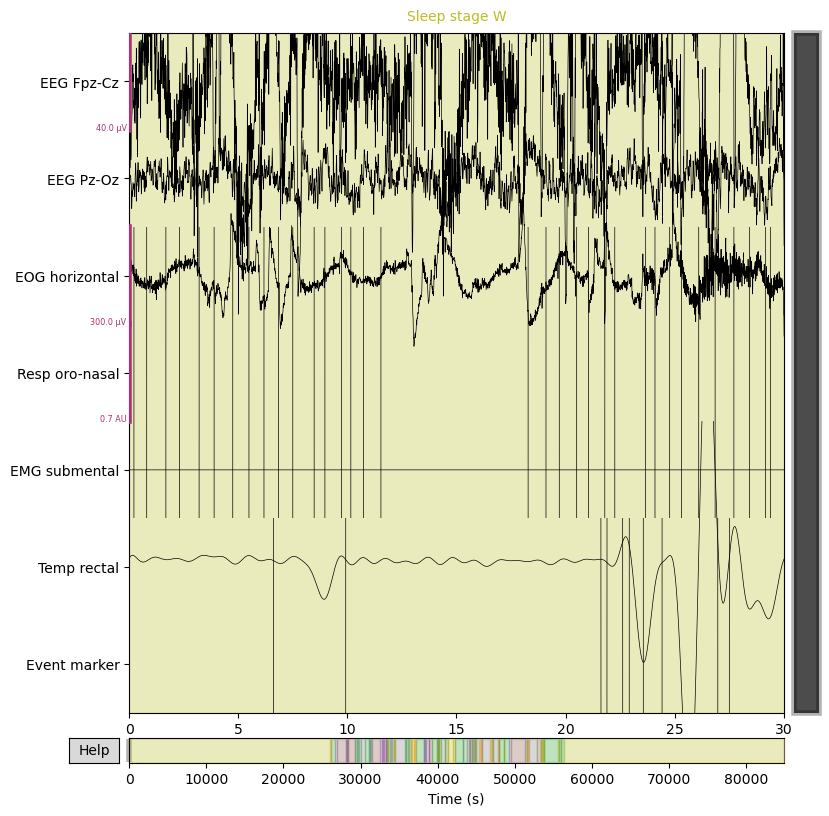

Used Annotations descriptions: ['Sleep stage 1', 'Sleep stage 2', 'Sleep stage 3', 'Sleep stage 4', 'Sleep stage R', 'Sleep stage W']


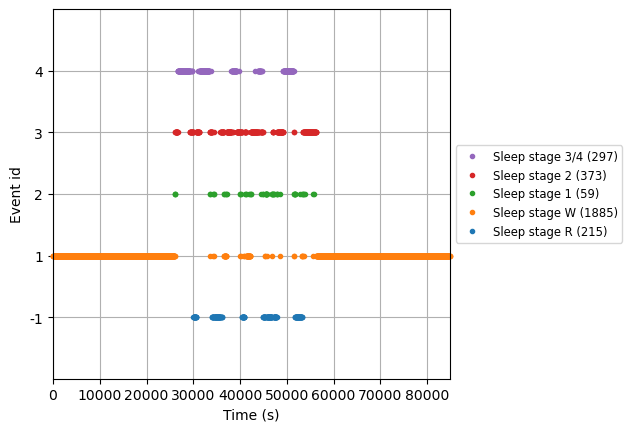

100%|██████████| 2/2 [00:10<00:00,  5.16s/it]


In [6]:
# plotting some of the subjects' raw signals and thier sleep stage
pdf_report = PdfPages('Sleep_Plots.pdf')
for item in tqdm(subject_files[:2]):  # selecting the first 2 subjects
    raw_train = mne.io.read_raw_edf(item[0][0], verbose=False)
    annot_train = mne.read_annotations(item[1][0])  # reading the hypnogram files

    raw_train.set_annotations(annot_train, emit_warning=False)
    raw_train.set_channel_types(mapping)
    figure = plt.figure()
    figure.suptitle("Subject: " + str(item[0][0][-13:-11]) + ", Night: " + str(item[0][0][-11:-10]))
    pdf_report.savefig(figure, bbox_inches='tight')
    pdf_report.savefig(raw_train.plot(duration=30), bbox_inches='tight')

    annotation_desc_2_event_id = {'Sleep stage R': -1,
                                  'Sleep stage W': 1,
                                  'Sleep stage 1': 2,
                                  'Sleep stage 2': 3,
                                  'Sleep stage 3': 4,
                                  'Sleep stage 4': 4
    }

    events_train, _ = mne.events_from_annotations(
        raw_train, event_id=annotation_desc_2_event_id, chunk_duration=30.)

    # create a new event_id that unifies stages 3 and 4
    event_id = {'Sleep stage R'  : -1,
                'Sleep stage W'  : 1,
                'Sleep stage 1'  : 2,
                'Sleep stage 2'  : 3,
                'Sleep stage 3/4': 4
    }
    # plot events and saving them in PDF report
    fig = mne.viz.plot_events(events_train, event_id=event_id, sfreq=raw_train.info['sfreq'])
    pdf_report.savefig(fig, bbox_inches='tight')
pdf_report.close()

<h3> Features Extraction </h3>


In [35]:
Fs= 100
band_list = [0.5,4,7,12,30]
PSD = []  # Power Spectral Density
PFD = []  # Petrosian Fractal Dimension
hjorths = []  # Hjorth Parameters
hursts = []  # Hurst Exponent
DFA = []  # Detrended Fluctuation Analysis
for item in tqdm(subject_files[:5]):
    raw_test = mne.io.read_raw_edf(item[0][0], verbose=False)
    signals_list = raw_test[0][0][0]
    first_order = np.diff(signals_list).tolist()
    PSD.append(pyeeg.bin_power(signals_list, band_list, Fs))
    PFD.append(pyeeg.pfd(signals_list, first_order))
    hjorths.append(pyeeg.hjorth(signals_list, first_order))
    hursts.append(compute_Hc(signals_list, kind='change', min_window=100))
    DFA.append(pyeeg.dfa(signals_list))

  0%|          | 0/5 [00:03<?, ?it/s]


KeyboardInterrupt: 

In [8]:
if VBS:
    print("Petrosian Fractal Dimension (PFD): ", PFD)
    print("Hjorth mobility and complexity: ", hjorths)
    print("Detrended Fluctuation Analysis (DFA): ", DFA)
    print("Hurst Exponent (Hurst): ", hursts)

Petrosian Fractal Dimension (PFD):  [0.5260813226365344, 0.524797335166937, 0.5296215973392818, 0.5294222017464901, 0.5267916487609091]
Hjorth mobility and complexity:  [(0.0001242622534516733, 13143.036280788516), (0.00018132418018598445, 9335.362942673955), (5.907335927673209e-05, 20875.12130562849), (6.000383534000729e-05, 21344.445095750732), (9.11423315792555e-05, 17072.109438632604)]
Detrended Fluctuation Analysis (DFA):  [0.13913468824876554, 0.2394063503787971, 0.19817581210316132, 0.2009850559755575, 0.19821142314924317]
Hurst Exponent (Hurst):  [(0.5835558023705111, 1.9675214804449521, [[100, 177, 316, 562, 1000, 1778, 3162, 5623, 10000, 17782, 31622, 56234, 100000, 177827, 316227, 562341, 1000000, 1778279, 3162277, 5623413, 7950000], [66.155289324895, 78.03278176625084, 92.8269827023827, 109.1797641429729, 127.685467256491, 148.35310840475495, 170.87570151326753, 199.11435939199475, 236.607566194322, 295.30064301639317, 401.0119507395091, 567.6520016324292, 867.8478412872066

<h3> Reading NPZ files for training dataset </h3>


In [7]:
npz_files = sorted(glob.glob(os.path.join(output_path, "*.npz")))
X = np.zeros((0, 3000, 1))
y = []
for fn in tqdm(npz_files[:number_of_subj]):
    samples = np.load(fn)
    X_data = samples['x']
    X = np.concatenate((X, X_data), axis=0)
    y.extend(samples['y'])
y = np.array(y)

100%|██████████| 50/50 [00:14<00:00,  3.50it/s]


In [12]:
from sklearn.manifold import TSNE

# Assuming X is your high-dimensional data with shape n*3000*1
X_dr = np.reshape(X, (X.shape[0], -1))
# Initialize t-SNE
tsne = TSNE(n_components=3, random_state=0)

# Apply t-SNE
X_10d = tsne.fit_transform(X_dr)
print(X_10d.shape)


(55989, 3)


In [36]:
X = np.reshape(X_10d, (X_10d.shape[0], 3, 1))
print(X.shape)

(55989, 3, 1)


Text(0.5, 1.0, 'Frequency of the labels in our dataset')

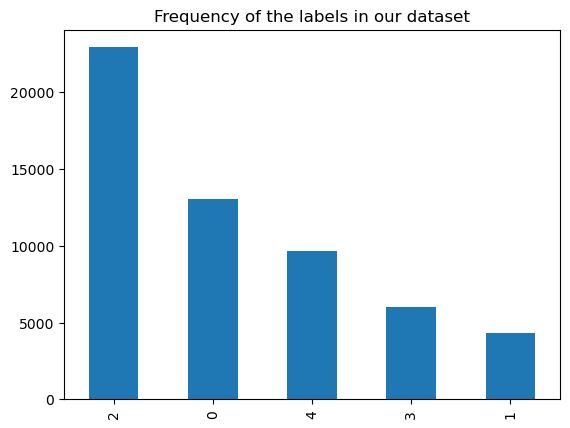

In [37]:
pd.Series(y).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

In [38]:
if VBS:
    print("Shape of the input data: {}".format(X.shape))
    print("Shape of the sleep stages: {}".format(y.shape))
# splitting subjects
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=seed)
# splitting sleeping signals
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=seed)
if VBS:
    print("Shape of the training dataset:\ntraining dataset: {}\ntest_dataset: {}\n"
          .format(X_train.shape, X_test.shape))
    
from imblearn.over_sampling import SMOTE

# X_train = np.reshape(X_train, (X_train.shape[0], -1))
# smote = SMOTE(sampling_strategy='auto', random_state=42)
# X_train, y_train = smote.fit_resample(X_train, y_train)
# X_train = np.reshape(X_train, (X_train.shape[0], 3, 1))
    

y_train_ = to_categorical(y_train)
y_val_ = to_categorical(y_val)
y_test_ = to_categorical(y_test)

Shape of the input data: (55989, 3, 1)
Shape of the sleep stages: (55989,)
Shape of the training dataset:
training dataset: (45351, 3, 1)
test_dataset: (5599, 3, 1)



Text(0.5, 1.0, 'Frequency of the labels in our dataset')

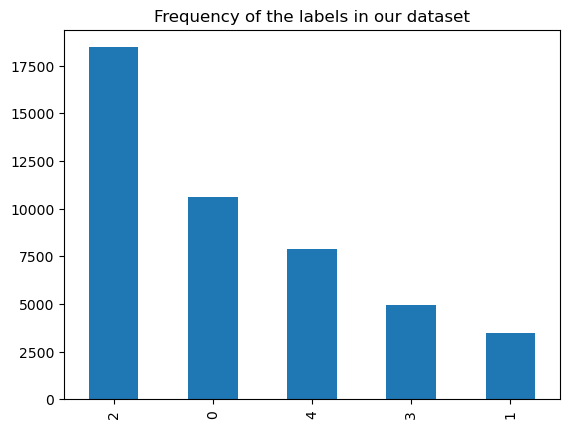

In [39]:
pd.Series(y_train).value_counts().plot.bar()
plt.title("Frequency of the labels in our dataset")

<h3>Normalization</h3>


In [40]:
def butter_bandpass(lowcut, highpass, fs, order=4):
    nyq = 0.5 * fs
    high = highpass / nyq
    b, a = butter(order, high, btype='highpass')
    return b, a
   
def butter_bandpass_filter(data, highpass, fs, order=4):
    b, a = butter_bandpass(0, highpass, fs, order=order)
    y = lfilter(b, a, data)
    return y   

In [41]:
pp_X_train = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_train])
pp_X_val = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_val])
pp_X_test = np.array([butter_bandpass_filter(sample, highpass=40.0, fs=100, order=4) for sample in X_test])
if VBS:
    print(pp_X_val.shape)
    print(pp_X_train.shape)

(5039, 3, 1)
(45351, 3, 1)


In [42]:
print(X_train.shape)
print(y_train_.shape)

(45351, 3, 1)
(45351, 5)


<h3>Callbacks</h3>


In [43]:
checkpoint = ModelCheckpoint("model_cps", monitor='val_loss', verbose=1, save_best_only=True, mode='max')
redonplat = ReduceLROnPlateau(monitor="val_loss", mode="max", patience=5, verbose=2)
csv_logger = CSVLogger('log_training.csv', append=True, separator=',')
callbacks_list = [
    checkpoint,
    redonplat,
    csv_logger,
]

<h3> CNN Model </h3>


In [38]:
model_cnn = models.model_cnn()
hist_cnn = model_cnn.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=20, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

In [ ]:
y_pred = model_cnn.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_cnn = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_cnn))
    report = classification_report(y_test, y_pred)
    print(report)

88/88 [==============================] - 6s 57ms/step
F1 score: 0.6568980451727984
              precision    recall  f1-score   support

           0       0.85      0.89      0.87      1231
           1       0.31      0.08      0.12       435
           2       0.82      0.88      0.85      2341
           3       0.84      0.80      0.82       613
           4       0.59      0.67      0.63       979

    accuracy                           0.77      5599
   macro avg       0.68      0.66      0.66      5599
weighted avg       0.75      0.77      0.75      5599



<AxesSubplot:>

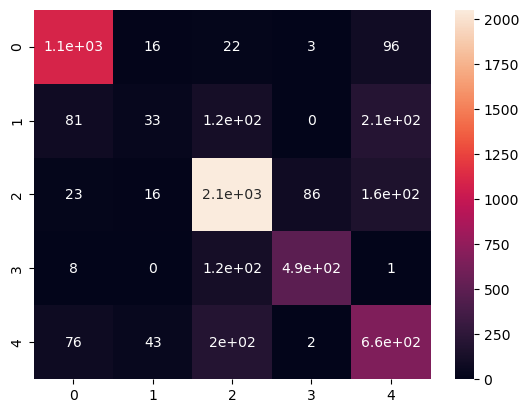

In [ ]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True)

In [31]:
plt.plot(hist_cnn.history["loss"],color='b',label='Loss')
plt.plot(hist_cnn.history["val_loss"],color='r',label='Val_Loss')
plt.legend()
plt.show()

NameError: name 'hist_cnn' is not defined

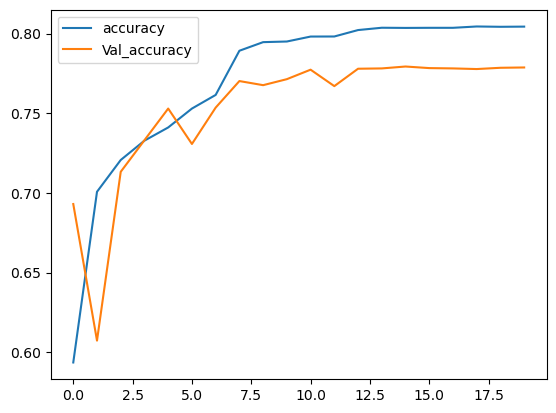

In [19]:
plt.plot(hist_cnn.history["acc"],label='accuracy')
plt.plot(hist_cnn.history["val_acc"],label='Val_accuracy')
plt.legend()
plt.show()

In [50]:
joblib.dump(model_cnn, 'Models/model_cnn.joblib')

['Models/model_cnn.joblib']

In [51]:
model_cnn.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inLayer (InputLayer)        [(None, 3000, 1)]         0         
                                                                 
 conv1d (Conv1D)             (None, 2996, 16)          96        
                                                                 
 conv1d_1 (Conv1D)           (None, 2992, 16)          1296      
                                                                 
 max_pooling1d (MaxPooling1  (None, 1496, 16)          0         
 D)                                                              
                                                                 
 conv1d_2 (Conv1D)           (None, 1494, 32)          1568      
                                                                 
 conv1d_3 (Conv1D)           (None, 1492, 32)          3104      
                                                             

<h3> Temporal CNN Model </h3>


In [75]:
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import TimeDistributed, SpatialDropout1D, GlobalMaxPool1D, concatenate, LSTM, Reshape, Input, Conv1D, MaxPool1D, Dropout, LocallyConnected1D, Concatenate, Dense, Flatten
from tcn import TCN

In [76]:
def model_tcnn3d():
    # Define model1
    inputLayer = Input(shape=(300, 1), name='inLayer')
    conv1 = Conv1D(64, kernel_size=200, activation='selu', strides=20, padding="valid", name='layer_11')(inputLayer)
    conv1 = Conv1D(64, kernel_size=6, activation='selu', padding="valid", name='layer_12')(conv1)
    conv1 = MaxPool1D(pool_size=3, strides=3)(conv1)
    conv1 = Conv1D(32, kernel_size=6, activation='selu', padding="valid", name='layer_13')(conv1)
    conv1 = Conv1D(32, kernel_size=6, activation='selu', padding="valid", name='layer_14')(conv1)
    conv1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    conv1 = Conv1D(32, kernel_size=3, activation='selu', padding="valid", name='layer_15', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001))(conv1)
    conv1 = Conv1D(32, kernel_size=3, activation='selu', padding="valid", name='layer_16')(conv1)
    conv1 = MaxPool1D(pool_size=2, strides=2)(conv1)
    conv1 = Dropout(rate=0.01)(conv1)
    conv1 = LocallyConnected1D(128, kernel_size=3, activation='selu', padding="valid", name='layer_17', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(conv1)
    conv1 = MaxPool1D()(conv1)
    conv1 = Dropout(rate=0.01)(conv1)
    conv1 = Flatten(name='flattened_model1')(conv1)

    # Define model3
    conv3 = Conv1D(64, kernel_size=25, strides=3, activation='selu', padding="valid", name='layer_31')(inputLayer)
    conv3 = Conv1D(64, kernel_size=8, activation='selu', padding="valid", name='layer_32')(conv3)
    conv3 = MaxPool1D(pool_size=4, strides=4)(conv3)
    conv3 = Conv1D(32, kernel_size=8, activation='selu', padding="valid", name='layer_33')(conv3)
    conv3 = Conv1D(32, kernel_size=8, activation='selu', padding="valid", name='layer_34')(conv3)
    conv3 = MaxPool1D(pool_size=2, strides=2)(conv3)
    conv3 = Conv1D(32, kernel_size=5, activation='selu', padding="valid", name='layer_25', kernel_regularizer=l1_l2(l1=0.0001, l2=0.001))(conv3)
    conv3 = Conv1D(32, kernel_size=5, activation='selu', padding="valid", name='layer_26')(conv3)
    conv3 = MaxPool1D(pool_size=2, strides=2)(conv3)
    conv3 = Dropout(rate=0.01)(conv3)
    conv3 = LocallyConnected1D(128, kernel_size=3, activation='selu', padding="valid", name='layer_37', kernel_regularizer=l1_l2(l1=0.0001, l2=0.0001))(conv3)
    conv3 = MaxPool1D()(conv3)
    conv3 = Dropout(rate=0.01)(conv3)
    conv3 = Flatten(name='flattened_model3')(conv3)

    nclass = 5

    outLayer = Concatenate()([conv1, conv3])
    outLayer = Reshape((1,outLayer.get_shape()[1]), name='reshape1')(outLayer)


    # TCN Layer
    outLayer = TCN(return_sequences=True, name='flaten1')(outLayer)

    # Output layer
    outLayer = Dense(nclass, activation="softmax")(outLayer)
    outLayer = Reshape((nclass,), name='reshape2')(outLayer)

    # Create the final model
    model = Model(inputLayer, outLayer)

    # Compile the model
    model.compile(optimizer=Adam(0.001, amsgrad=True), sample_weight_mode="temporal", loss='categorical_crossentropy', metrics=['acc'])

    return model

In [77]:
model_tcnn = model_tcnn3d()
hist_tcnn = model_tcnn.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=20, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

ValueError: Exception encountered when calling layer "max_pooling1d_17" (type MaxPooling1D).

Negative dimension size caused by subtracting 3 from 1 for '{{node max_pooling1d_17/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 3, 1, 1], padding="VALID", strides=[1, 3, 1, 1]](max_pooling1d_17/ExpandDims)' with input shapes: [?,1,1,64].

Call arguments received by layer "max_pooling1d_17" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 1, 64), dtype=float32)

In [22]:
y_pred = model_tcnn.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_tcnn = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_tcnn))
    report = classification_report(y_test, y_pred)
    print(report)

88/88 [==============================] - 4s 42ms/step
F1 score: 0.7077739428863247
              precision    recall  f1-score   support

           0       0.87      0.92      0.89      1231
           1       0.30      0.35      0.32       435
           2       0.87      0.80      0.83      2341
           3       0.71      0.90      0.80       613
           4       0.76      0.64      0.69       979

    accuracy                           0.78      5599
   macro avg       0.70      0.72      0.71      5599
weighted avg       0.79      0.78      0.78      5599



<AxesSubplot:>

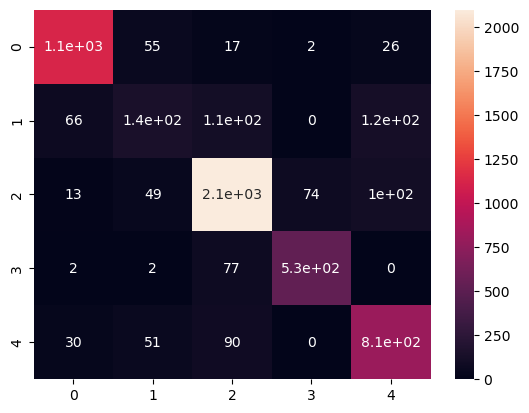

In [23]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True)

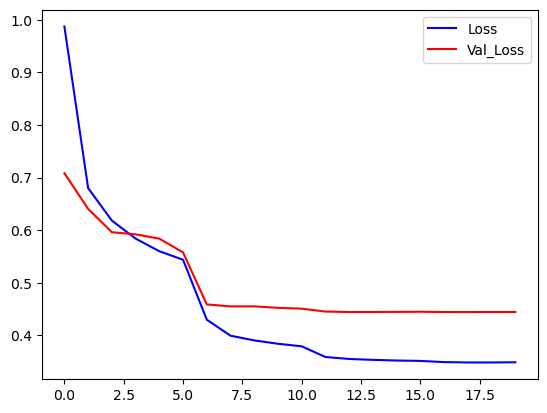

In [24]:
plt.plot(hist_tcnn.history["loss"],color='b',label='Loss')
plt.plot(hist_tcnn.history["val_loss"],color='r',label='Val_Loss')
plt.legend()
plt.show()

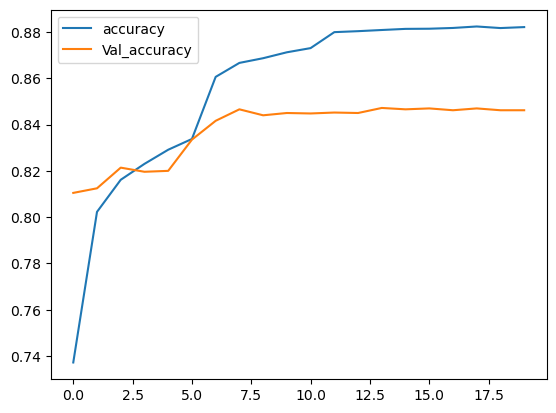

In [52]:
plt.plot(hist_tcnn.history["acc"],label='accuracy')
plt.plot(hist_tcnn.history["val_acc"],label='Val_accuracy')
plt.legend()
plt.show()

In [38]:
joblib.dump(model_tcnn, 'Models/model_tcnn.joblib')

['Models/model_tcnn.joblib']

In [53]:
model_tcnn.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 inLayer (InputLayer)        [(None, 3000, 1)]            0         []                            
                                                                                                  
 layer_11 (Conv1D)           (None, 141, 64)              12864     ['inLayer[0][0]']             
                                                                                                  
 layer_31 (Conv1D)           (None, 992, 64)              1664      ['inLayer[0][0]']             
                                                                                                  
 layer_12 (Conv1D)           (None, 136, 64)              24640     ['layer_11[0][0]']            
                                                                                            

<h3> LSTM Model </h3>


In [80]:
WINDOW_SIZE = 100
Fs = 100

In [81]:
def model_lstm3d(n_classes=5, use_sub_layer=False, use_rnn=True, verbose=False):
    inputLayer = Input(shape=(300, 1), name='inLayer')
    convFine = Conv1D(filters=64, kernel_size=int(Fs/2), strides=int(Fs/16), padding='same', activation='relu', name='fConv1')(inputLayer)
    convFine = MaxPool1D(pool_size=8, strides=8, name='fMaxP1')(convFine)
    convFine = Dropout(rate=0.5, name='fDrop1')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv2')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv3')(convFine)
    convFine = Conv1D(filters=128, kernel_size=8, padding='same', activation='relu', name='fConv4')(convFine)
    convFine = MaxPool1D(pool_size=4, strides=4, name='fMaxP2')(convFine)
    fineShape = convFine.get_shape()
    convFine = Flatten(name='fFlat1')(convFine)
    
    # network to learn coarse features
    convCoarse = Conv1D(filters=32, kernel_size=Fs*4, strides=int(Fs/2), padding='same', activation='relu', name='cConv1')(inputLayer)
    convCoarse = MaxPool1D(pool_size=4, strides=4, name='cMaxP1')(convCoarse)
    convCoarse = Dropout(rate=0.5, name='cDrop1')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv2')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv3')(convCoarse)
    convCoarse = Conv1D(filters=128, kernel_size=6, padding='same', activation='relu', name='cConv4')(convCoarse)
    convCoarse = MaxPool1D(pool_size=2, strides=2, name='cMaxP2')(convCoarse)
    coarseShape = convCoarse.get_shape()
    convCoarse = Flatten(name='cFlat1')(convCoarse)
    
    # concatenate coarse and fine cnns
    mergeLayer = concatenate([convFine, convCoarse], name='merge_1')
    outLayer = Dropout(rate=0.5, name='mDrop1')(mergeLayer)
    
    outLayer = Reshape((1, outLayer.get_shape()[1]), name='reshape1')(outLayer)
    outLayer = LSTM(64, return_sequences=True)(outLayer)
    outLayer = LSTM(64, return_sequences=False)(outLayer)
    outLayer = Dense(n_classes, activation='softmax', name='outLayer')(outLayer)
    
    model = Model(inputLayer, outLayer)
    
    model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['acc'])

    return model

In [82]:
model_lstm = model_lstm3d(verbose=VBS)
hist_lstm = model_lstm.fit(
    pp_X_train, y_train_, batch_size=batch_size, epochs=20, validation_data=(pp_X_val, y_val_), callbacks=callbacks_list, verbose=VBS
)

ValueError: Exception encountered when calling layer "cMaxP2" (type MaxPooling1D).

Negative dimension size caused by subtracting 2 from 1 for '{{node cMaxP2/MaxPool}} = MaxPool[T=DT_FLOAT, data_format="NHWC", explicit_paddings=[], ksize=[1, 2, 1, 1], padding="VALID", strides=[1, 2, 1, 1]](cMaxP2/ExpandDims)' with input shapes: [?,1,1,128].

Call arguments received by layer "cMaxP2" (type MaxPooling1D):
  • inputs=tf.Tensor(shape=(None, 1, 128), dtype=float32)

In [61]:
y_pred = model_lstm.predict(pp_X_test, batch_size=batch_size)
y_pred = np.array([np.argmax(s) for s in y_pred])
f1_lstm = f1_score(y_test, y_pred, average="macro")
if VBS:
    print("F1 score: {}".format(f1_lstm))
    report = classification_report(y_test, y_pred)
    print(report)

88/88 [==============================] - 1s 15ms/step
F1 score: 0.764083188445646
              precision    recall  f1-score   support

           0       0.90      0.93      0.91      1231
           1       0.46      0.28      0.35       435
           2       0.88      0.89      0.89      2341
           3       0.87      0.88      0.87       613
           4       0.76      0.84      0.80       979

    accuracy                           0.84      5599
   macro avg       0.77      0.76      0.76      5599
weighted avg       0.83      0.84      0.83      5599



<AxesSubplot:>

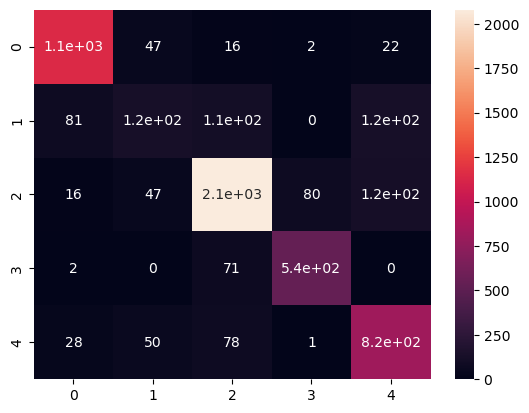

In [62]:
cm = confusion_matrix(y_test,y_pred)
sns.heatmap(cm, annot=True)

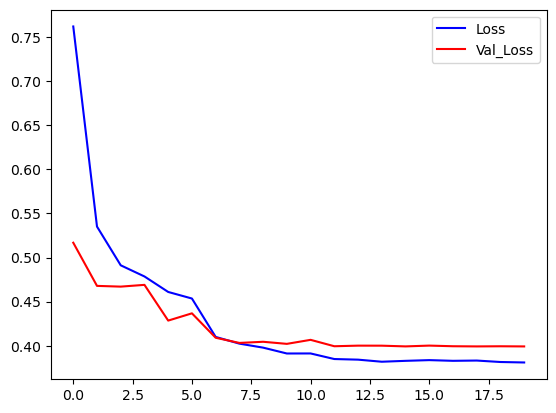

In [63]:
plt.plot(hist_lstm.history["loss"],color='b',label='Loss')
plt.plot(hist_lstm.history["val_loss"],color='r',label='Val_Loss')
plt.legend()
plt.show()

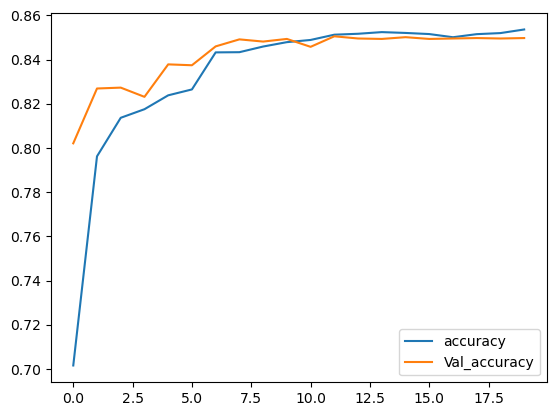

In [64]:
plt.plot(hist_lstm.history["acc"],label='accuracy')
plt.plot(hist_lstm.history["val_acc"],label='Val_accuracy')
plt.legend()
plt.show()

In [65]:
joblib.dump(model_lstm, 'Models/model_lstm.joblib')

['Models/model_lstm.joblib']

In [1]:
model_lstm.summary()

NameError: name 'model_lstm' is not defined

<h3>Other Classifiers</h3>


In [44]:
classifiers = [
    KNeighborsClassifier(5),
    DecisionTreeClassifier(),
    RandomForestClassifier(),
    XGBClassifier(),
    AdaBoostClassifier(),
    GaussianNB(),
    LinearDiscriminantAnalysis(),
    QuadraticDiscriminantAnalysis()]

In [45]:
# logging for visual comparison
log_cols=["Classifier", "Accuracy"]
log = pd.DataFrame(columns=log_cols)
X_train_squeezed = np.squeeze(X_train)
X_test_squeezed = np.squeeze(X_test)
for clf in classifiers:
    clf.fit(X_train_squeezed, y_train)
    name = clf.__class__.__name__
    train_predictions = clf.predict(X_test_squeezed)
    acc = accuracy_score(y_test, train_predictions)
    if VBS:
        print("-"*27)
        print(name + " Accuracy: {:.2%}".format(acc))
    log = log._append({'Classifier':name, 'Accuracy':acc*100},ignore_index=True)

---------------------------
KNeighborsClassifier Accuracy: 39.19%
---------------------------
DecisionTreeClassifier Accuracy: 30.84%
---------------------------
RandomForestClassifier Accuracy: 41.85%
---------------------------
XGBClassifier Accuracy: 44.65%
---------------------------
AdaBoostClassifier Accuracy: 43.49%
---------------------------
GaussianNB Accuracy: 42.60%
---------------------------
LinearDiscriminantAnalysis Accuracy: 42.38%
---------------------------
QuadraticDiscriminantAnalysis Accuracy: 42.81%


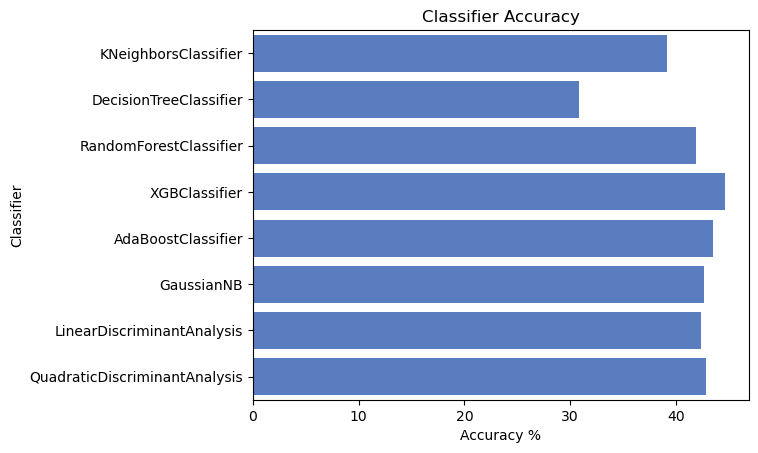

In [46]:
# Code for bar plot for comparing different models
pdf_report2 = PdfPages('Classifiers_Results.pdf')
fig1 = plt.figure()
sns.set_color_codes("muted")
sns.barplot(x='Accuracy', y='Classifier', data=log, color="b")
plt.xlabel('Accuracy %')
plt.title('Classifier Accuracy')
pdf_report2.savefig(fig1, bbox_inches='tight')
plt.show()